# 进港、出港航班

获取单天的航班的计划出站时间和实际到达时间，由此可以计算出
1. 计划任务执行时间
2. 实际任务执行时间

In [73]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
# 导入中文字体
font_path = './微软雅黑.ttf'  # 例如，SimHei.ttf
my_font = fm.FontProperties(fname=font_path)


In [74]:
df_in = pd.read_excel('../dataset/机务维修中心进港2月.xlsx')
df_out = pd.read_excel('../dataset/机务维修中心出港2月.xlsx')

df_in['计达时间'] = pd.to_datetime(df_in['计达时间'])
df_in['实达时间'] = pd.to_datetime(df_in['实达时间'])
df_out['计飞时间'] = pd.to_datetime(df_out['计飞时间'])
df_out['实飞时间'] = pd.to_datetime(df_out['实飞时间'])
# 新增 date 列
df_in['plan_date'] = df_in['计达时间'].dt.date
df_out['plan_date'] = df_out['计飞时间'].dt.date
# 新增 time列
df_in['plan_time'] = df_in['计达时间'].dt.time
df_out['plan_time'] = df_out['计飞时间'].dt.time
# 新增 实际 
df_in['actual_date'] = df_in['实达时间'].dt.date
df_out['actual_date'] = df_out['实飞时间'].dt.date
# 新增 time列
df_in['actual_time'] = df_in['实达时间'].dt.time
df_out['actual_time'] = df_out['实飞时间'].dt.time



In [75]:
df_in.columns

Index(['工号', '姓名', '航班号', '航班类别', '机号', '机型', '机位', '任务名', '部门', '计达时间',
       '实达时间', '派工时间', '任务状态', '任务确认时间', '任务开始时间', '任务结束时间', '备注', 'plan_date',
       'plan_time', 'actual_date', 'actual_time'],
      dtype='object')

In [76]:
# 根据停机坪对航班信息进行过滤

# 获取停机坪信息
df_parking = pd.read_excel('../dataset/Gate_lounge.xlsx')
# 将停机口转化为字符串
df_parking['停机口'] = df_parking['停机口'].astype(str)
print('Before filter:',len(df_in))
print('Before filter:',len(df_out))
# df_in 在 df_parking 中的停机口
df_in = df_in[df_in['机位'].isin(df_parking['停机口'])]
# df_out 在 df_parking 中的停机口
df_out = df_out[df_out['机位'].isin(df_parking['停机口'])]
print('After filter:',len(df_in))
print('After filter:',len(df_out))

Before filter: 40386
Before filter: 45436
After filter: 36325
After filter: 40912


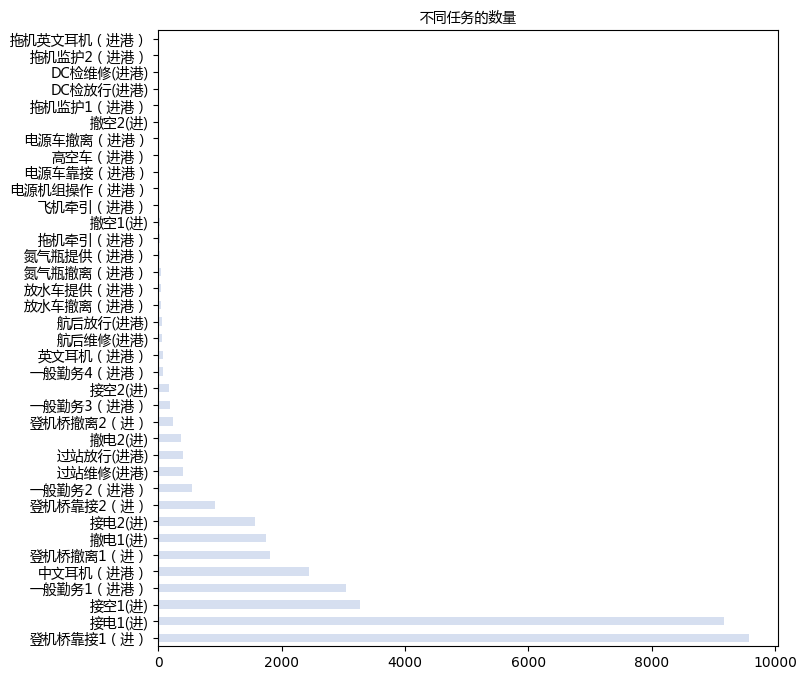

In [77]:
# 绘制不同任务的占比
plt.figure(figsize=(8, 8))
df_in['任务名'].value_counts().plot(kind='barh',color='#d6dff0')
plt.title('不同任务的数量', fontproperties=my_font)
plt.yticks(fontproperties=my_font)
plt.show()

In [78]:
# 进行任务类型的过滤

keywords = {'车','拖','瓶','检'}
# 删除任务名中包含关键字的行
print('Before filter:',len(df_in))
print('Before filter:',len(df_out))
df_in = df_in[~df_in['任务名'].str.contains('|'.join(keywords))]
df_out = df_out[~df_out['任务名'].str.contains('|'.join(keywords))]
print('After filter:',len(df_in))
print('After filter:',len(df_out))

Before filter: 36325
Before filter: 40912
After filter: 36108
After filter: 40782


In [79]:
# 获取每个机型对应的最小人员数目

# 获取机型、plan_date、plan_time groupby 下的需要人员数目，为unique
df_in_group = df_in.groupby(['机型','plan_date','plan_time']).agg({'姓名':'nunique'}).reset_index()
# 获取机型下列的最小的人员数目
df_in_group = df_in_group.groupby(['机型']).agg({'姓名':'min'}).reset_index()

# 获取机型、plan_date、plan_time groupby 下的需要人员数目，为unique
df_out_group = df_out.groupby(['机型','plan_date','plan_time']).agg({'姓名':'nunique'}).reset_index()
# 获取机型下列的最小的人员数目
df_out_group = df_out_group.groupby(['机型']).agg({'姓名':'min'}).reset_index()

# 按照机型合并，姓名取最小值，df_in_group, df_out_group
df_in_group.rename(columns={'姓名':'进港'}, inplace=True)
df_out_group.rename(columns={'姓名':'出港'}, inplace=True)

df_group = pd.merge(df_in_group, df_out_group, on='机型', how='outer')
df_group.columns = ['机型', '进港', '出港']
df_group.fillna(0, inplace=True)
df_group['进港'] = df_group['进港'].astype(int)
df_group['出港'] = df_group['出港'].astype(int)

# 取进出港最小值
df_group['min'] = df_group[['进港', '出港']].min(axis=1)
df_group['min'] = df_group['min'].astype(int)
# 丢弃进出港列
df_group.drop(columns=['进港', '出港'], inplace=True)

df_group.to_excel('../dataset/机型最小人员数.xlsx', index=False)

In [80]:
# 对每个 plan time 下的人员列 unique，之后求和得到总派工人次数
df_in_group = df_in.groupby(['机型','plan_date','plan_time']).agg({'姓名':'nunique'}).reset_index()
df_in_group = df_in_group.groupby(['机型','plan_date']).agg({'姓名':'sum'}).reset_index()
df_in_group.rename(columns={'姓名':'进港'}, inplace=True)

df_out_group = df_out.groupby(['机型','plan_date','plan_time']).agg({'姓名':'nunique'}).reset_index()
df_out_group = df_out_group.groupby(['机型','plan_date']).agg({'姓名':'sum'}).reset_index()
df_out_group.rename(columns={'姓名':'出港'}, inplace=True)

df_group = pd.merge(df_in_group, df_out_group, on=['机型','plan_date'], how='outer')
df_group.fillna(0, inplace=True)
df_group['进港'] = df_group['进港'].astype(int)
df_group['出港'] = df_group['出港'].astype(int)
df_group['总人次'] = df_group['进港'] + df_group['出港']
print(sum(df_group['进港']))
print(sum(df_group['出港']))
print(sum(df_group['总人次']))

17528
21906
39434


In [81]:
# 获取航班信息

print(df_in.columns)
df_in.drop(['姓名','工号','部门','任务状态','任务名','任务确认时间','任务开始时间','任务结束时间','派工时间','备注','计达时间','实达时间'], inplace=True,axis=1)
print(df_in.columns)
# 去除重复
print('Before unique:',len(df_in))
df_in.drop_duplicates(inplace=True)
print('After unique:',len(df_in))
df_out.drop(['姓名','工号','部门','任务状态','任务名','任务确认时间','任务开始时间','任务结束时间','派工时间','备注','计飞时间','实飞时间'], inplace=True,axis=1)
# 去除重复
print('Before unique:',len(df_out))
df_out.drop_duplicates(inplace=True)
print('After unique:',len(df_out))

Index(['工号', '姓名', '航班号', '航班类别', '机号', '机型', '机位', '任务名', '部门', '计达时间',
       '实达时间', '派工时间', '任务状态', '任务确认时间', '任务开始时间', '任务结束时间', '备注', 'plan_date',
       'plan_time', 'actual_date', 'actual_time'],
      dtype='object')
Index(['航班号', '航班类别', '机号', '机型', '机位', 'plan_date', 'plan_time',
       'actual_date', 'actual_time'],
      dtype='object')
Before unique: 36108
After unique: 9521
Before unique: 40782
After unique: 9569


Text(0.5, 1.0, 'Number of inbound and outbound tasks per day')

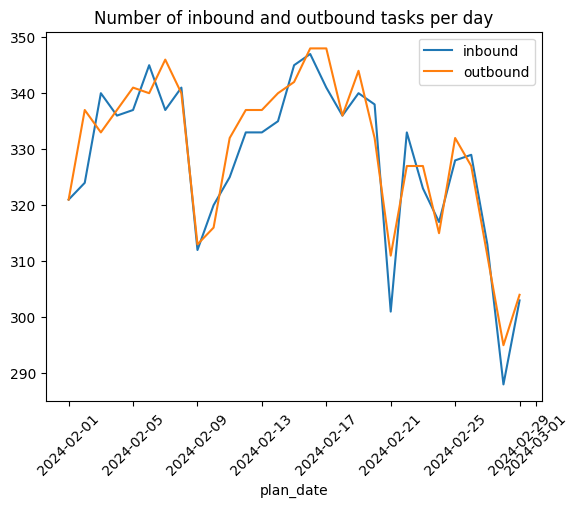

In [82]:
df_in.groupby('plan_date').size().plot()
df_out.groupby('plan_date').size().plot()
plt.legend(['inbound', 'outbound'])
plt.xticks(rotation=45)
plt.title('Number of inbound and outbound tasks per day')

In [83]:
df_air = pd.read_excel('../dataset/航司资质要求.xlsx')
# 删除航班类型为 '货' 的行
df_air = df_air[df_air['航班类型'] != '货']
# 填补 一般勤务 非1 的行为 0
df_air.loc[df_air['一般勤务']!=1,'一般勤务'] = 0
df_air['一般勤务'] = df_air['一般勤务'].astype(int)
# 填补 机务勤务 非1 的行为 0
df_air.loc[df_air['放行机务']!=1,'放行机务'] = 0
df_air['放行机务'] = df_air['放行机务'].astype(int)

df_air.loc[df_air['维修机务']!=1,'维修机务'] = 0
df_air['维修机务'] = df_air['维修机务'].astype(int)

df_air.loc[df_air['英文耳机']!=1,'英文耳机'] = 0
df_air['英文耳机'] = df_air['英文耳机'].astype(int)

df_air.loc[df_air['中文耳机']!=1,'中文耳机'] = 0
df_air['中文耳机'] = df_air['中文耳机'].astype(int)

df_air.drop(['序号'],axis=1,inplace=True)

In [84]:
df_air.head()
df_air.to_excel('../dataset/new_aviationCompany.xlsx',index=False)

In [85]:
# 保存到 航空公司保存到航班号前 2
df_in['航空公司'] = df_in['航班号'].str[:2]
df_in.drop(['航班号'], inplace=True, axis=1)
df_out['航空公司'] = df_out['航班号'].str[:2]
df_out.drop(['航班号'], inplace=True, axis=1)

In [86]:
print(df_in.head())
print(df_out.head())

   航班类别     机号    机型   机位   plan_date plan_time actual_date actual_time 航空公司
0   PAX  B1373  B738  179  2024-02-29  23:55:00  2024-03-01    00:15:00   HU
8   PAX  B6751  A320  170  2024-02-29  23:55:00  2024-02-29    23:29:00   9C
12  PAX  B8641  A321  164  2024-02-29  23:50:00  2024-02-29    23:38:00   CZ
17  PAX  B8503  A321   88  2024-02-29  23:50:00  2024-02-29    23:17:00   CA
21  PAX  B8235  A320   80  2024-02-29  23:45:00  2024-02-29    23:20:00   HO
   航班类别      机号    机型   机位   plan_date plan_time actual_date actual_time 航空公司
6   PAX   A7BEX  B77W   71  2024-02-29  23:45:00  2024-03-01    00:05:00   QR
17  SPE   B209R  B789   87  2024-02-29  23:40:00  2024-03-01    00:15:00   HO
18  PAX   EPMMR  A346  168  2024-02-29  23:30:00  2024-03-01    04:20:00   W5
43  PAX  N2747U  B77W   63  2024-02-29  23:15:00  2024-02-29    23:38:00   UA
50  PAX   ETAUB  A359   73  2024-02-29  23:10:00  2024-02-29    23:31:00   ET


In [87]:
# 合并两个文件
df_in['type'] = 'inbound'
df_out['type'] = 'outbound'
df = pd.concat([df_in,df_out],axis=0)
# 按照 sort time 
df.sort_values(by='actual_time',inplace=True)
df.sort_values(by='actual_date',inplace=True)
# drop index
df.reset_index(drop=True,inplace=True)
print(df.head())
df.to_excel('../dataset/flights_obs.xlsx',index=False)

  航班类别       机号    机型   机位   plan_date plan_time actual_date actual_time 航空公司  \
0  PAX  RPC4124  A21N   87  2024-02-01  00:05:00  2024-01-31    23:49:00   5J   
1  PAX    9MXXU  A333   71  2024-02-01  00:20:00  2024-01-31    23:43:00   D7   
2  PAX    B1657  A320  171  2024-02-01  17:45:00  2024-02-01    17:43:00   9C   
3  PAX    B322Y  A359  170  2024-02-01  22:55:00  2024-02-01    22:55:00   CA   
4  PAX    B32EH  A21N   59  2024-02-01  01:55:00  2024-02-01    01:56:00   HO   

      type  
0  inbound  
1  inbound  
2  inbound  
3  inbound  
4  inbound  


In [91]:
print(len(df)/(len(df['plan_date'].unique())-1))

681.7857142857143


In [89]:
# 航空公司在 df_air['二字代码'] 中的数量
df['航空公司'].isin(df_air['二字代码']).sum()

6754

In [ ]:
# df中航空公司，但是在 df air 中没有的
res = set(df['航空公司'].unique()) - set(df_air['二字代码'].unique())
print(res)

{'RO', 'FD', '9C', 'GU', '3U', 'AF', 'B7', 'OS', 'NZ', 'VP', 'CZ', 'FJ', 'MA', 'SQ', 'K6', 'LD', 'HX', 'H9', 'AY', 'TG', 'TK', 'P4', 'RW', 'B6', 'UP', 'BA', 'N7', 'AQ', 'VN', 'BR', 'EU', 'MS', 'T7', 'HZ', 'IJ', 'HO', 'VJ', 'GK', 'SC', 'PO', 'Z2', 'N5', 'JB', 'B0', 'SK', 'OQ', 'N9', 'B8', 'SV', '2C', 'QQ', 'VZ', 'O3', 'PR', 'CB', 'GL', 'LX', 'N8', 'B3', 'EY', '5Y', 'LH', '5J', 'OZ', 'JX', 'AK', 'MH'}
